# Analysis 4: Unique States for Every Activation File

This notebook scans all experiment subdirectories under `runs/fashion_cv_l1_dropoutLows_l2`, imports each activation CSV, computes the number of unique rounded hidden states using `analysis.count_unique_states_rounding`, samples pairwise distances (optional), aggregates results per configuration, and produces a scatter plot of `num_states` vs validation accuracy. It also computes Pearson and Spearman correlations and includes a small section for clustering or distance-based summaries.

In [1]:
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import src.analysis.analysis as analysis

ROOT = Path('runs') / 'fashion_cv_l1_dropoutLows_l2'
ROOT = ROOT.resolve()
print('root exists:', ROOT.exists())

root exists: True


In [2]:
# Helpers to find all activation CSVs and matching metrics.csv
def find_all_activation_files(root: Path):
    files = []
    for param_dir in sorted(root.iterdir()):
        if not param_dir.is_dir():
            continue
        for fold in sorted(param_dir.iterdir()):
            if not fold.is_dir():
                continue
            # collect any activations CSVs in this fold
            for f in fold.glob('activations_collected_epoch*.csv'):
                files.append((param_dir.name, fold.name, f))
    return files

acts = find_all_activation_files(ROOT)
len(acts)

675

In [3]:
# Process each activation file: compute num_states only (fast)
rows = []
for param, fold, fpath in acts:
    try:
        df = pd.read_csv(fpath)
    except Exception as e:
        print('failed reading', fpath, e)
        continue
    act_cols = [c for c in df.columns if c.startswith('act_')]
    if not act_cols:
        act_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in ('pred_label', 'true_label')]
    X = df[act_cols].values


    try:
        n_states, reps = analysis.count_unique_states_rounding(X, decimals=2, normalize_l2=True)
    except Exception as e:
        print('count_unique failed for', fpath, e)
        n_states = None
    # try to read val acc for that fold (metrics.csv)
    metrics_file = Path(fpath).parent / 'metrics.csv'
    val_acc = np.nan
    if metrics_file.exists():
        try:
            m = pd.read_csv(metrics_file)
            val_acc = float(m['val_acc'].iloc[-1])
        except Exception:
            val_acc = np.nan
    rows.append({
        'param': param,
        'fold': fold,
        'file': str(fpath),
        'num_states': int(n_states) if n_states is not None else np.nan,
        'val_acc': val_acc
    })

df_results = pd.DataFrame(rows)

df_results.head()

,param,fold,file,num_states,val_acc
0,baseline,fold1,C:\Users\Adam\Desktop\tfg\code\runs\fashion_cv...,11696,0.859417
1,baseline,fold1,C:\Users\Adam\Desktop\tfg\code\runs\fashion_cv...,11706,0.859417
2,baseline,fold1,C:\Users\Adam\Desktop\tfg\code\runs\fashion_cv...,11735,0.859417
3,baseline,fold1,C:\Users\Adam\Desktop\tfg\code\runs\fashion_cv...,11695,0.859417
4,baseline,fold1,C:\Users\Adam\Desktop\tfg\code\runs\fashion_cv...,11692,0.859417


In [ ]:
# Build 'method' column and aggregate mean/std per method
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def infer_method(param: str) -> str:
    p = str(param).lower()
    if p.startswith('dropout'): return 'dropout'
    if p.startswith('l1'): return 'l1'
    if p.startswith('l2'): return 'l2'
    if p.startswith('baseline'): return 'baseline'
    return 'other'

dfm = df_results.copy()
dfm['method'] = dfm['param'].map(infer_method)

# aggregate mean/std by method
agg_method = dfm.groupby('method').agg(
    num_states_mean=('num_states','mean'),
    num_states_std=('num_states','std'),
    val_acc_mean=('val_acc','mean'),
    val_acc_std=('val_acc','std')
).reset_index()
agg_method

In [ ]:
# Combined scatter: per-file points colored by method
plt.figure(figsize=(8,6))
sns.scatterplot(data=dfm, x='num_states', y='val_acc', hue='method', alpha=0.8)
plt.xlabel('Num unique states (rounded)')
plt.ylabel('Validation accuracy (last epoch)')
plt.title('num_states vs val_acc (together, colored by method)')
plt.tight_layout()
plt.show()

In [ ]:
# Plot mean±std per method for num_states and val_acc
sns.set(style='whitegrid')
methods = agg_method['method'].tolist()
x = np.arange(len(methods))
w = 0.35
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Left: num_states mean±std
axes[0].errorbar(x, agg_method['num_states_mean'], yerr=agg_method['num_states_std'], fmt='o', capsize=4)
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods, rotation=0)
axes[0].set_title('Num states (mean ± std) por método')
axes[0].set_ylabel('num_states')

# Right: val_acc mean±std
axes[1].errorbar(x, agg_method['val_acc_mean'], yerr=agg_method['val_acc_std'], fmt='s', capsize=4, color='tab:orange')
axes[1].set_xticks(x)
axes[1].set_xticklabels(methods, rotation=0)
axes[1].set_title('Val accuracy (mean ± std) por método')
axes[1].set_ylabel('val_acc')

fig.tight_layout()
fig

# Num states vs validation accuracy by regularizer method
We now aggregate by regularization method (dropout, l1, l2, baseline, other) rather than by param value.
- First: mean ± std per method for num_states and val_acc.
- Then: a combined scatter of all points (per-file) colored by method.

Note: We ignore fold naming mismatches here; plots are based on per-file measurements only.

In [4]:
# Aggregate per configuration (param) by taking the mean num_states and val_acc across folds/files
agg = df_results.groupby('param').agg(num_states_mean=('num_states','mean'), num_states_std=('num_states','std'), val_acc_mean=('val_acc','mean'), val_acc_std=('val_acc','std')).reset_index()
agg

,param,num_states_mean,num_states_std,val_acc_mean,val_acc_std
0,baseline,11533.92,337.341434,0.849500,0.012549
1,dropout_p_0.0,11396.60,225.864266,0.850067,0.008271
2,dropout_p_0.1,11671.00,127.371177,0.852933,0.007897
3,dropout_p_0.15,11496.56,386.862926,0.843233,0.007933
4,dropout_p_0.2,10969.08,325.756545,0.841017,0.018122
5,dropout_p_0.25,11043.92,608.753434,0.826300,0.007883
6,dropout_p_0.3,10848.12,348.525862,0.833150,0.004955
7,dropout_p_0.35,9788.44,479.756282,0.826950,0.006832
8,dropout_p_0.4,8929.40,364.193859,0.800167,0.014328
9,dropout_p_0.45,8039.60,789.194420,0.766033,0.023064


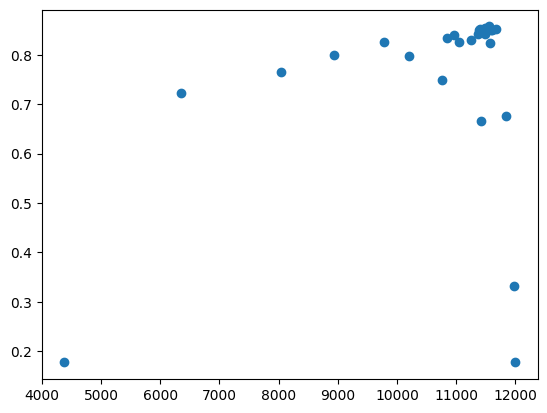

In [5]:
plt.scatter(agg['num_states_mean'], agg['val_acc_mean'])
plt.show()

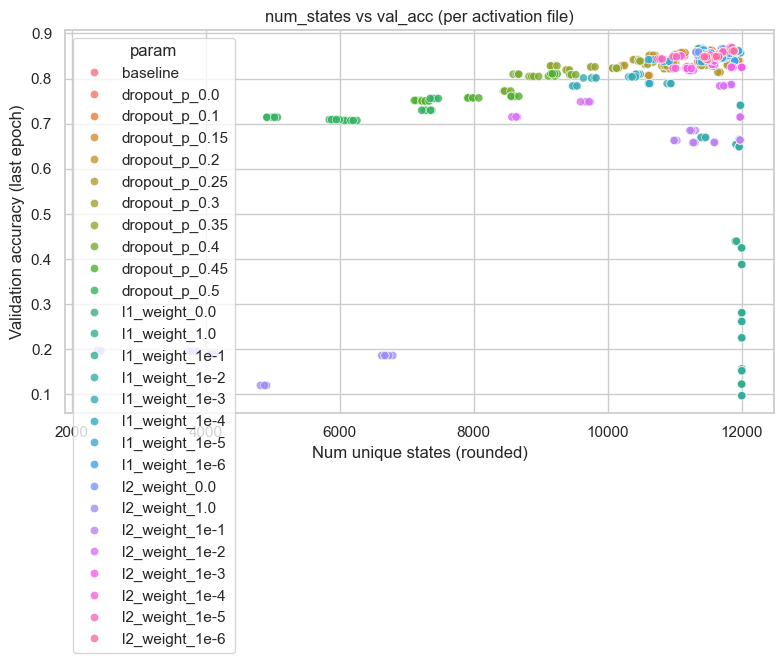

In [6]:
# Scatter num_states (per-file) vs val_acc and regression line
sns.set(style='whitegrid')
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_results, x='num_states', y='val_acc', hue='param', alpha=0.8)
plt.xlabel('Num unique states (rounded)')
plt.ylabel('Validation accuracy (last epoch)')
plt.title('num_states vs val_acc (per activation file)')
plt.tight_layout()
plt.show()

In [7]:
# Correlations: Pearson and Spearman between num_states and val_acc
from scipy.stats import pearsonr, spearmanr
mask = df_results['num_states'].notna() & df_results['val_acc'].notna()
if mask.sum() > 1:
    r_p, p_p = pearsonr(df_results.loc[mask,'num_states'], df_results.loc[mask,'val_acc'])
    r_s, p_s = spearmanr(df_results.loc[mask,'num_states'], df_results.loc[mask,'val_acc'])
    print('pearson r, p:', r_p, p_p)
    print('spearman r, p:', r_s, p_s)
else:
    print('Not enough data for correlations')

pearson r, p: 0.33206612262118174 7.71330638947477e-19
spearman r, p: 0.18637520115241468 1.0826944365666851e-06


### Finish and notes

- The notebook now computes only `num_states` (rounded unique hidden states) to keep execution fast. Change `decimals` in the processing cell to tune sensitivity.
- If you want longer analyses (pairwise distances, clustering, per-class counts), we can add those later as optional cells.
- To export results, add a cell to save `df_results.to_csv('outs/df_results_analysis4.csv', index=False)`.

# Activations manifold visualization: PCA, t-SNE, Isomap, Spectral, LLE
In this section we project 64-D activation vectors to 2D to inspect clustering, directions, and decision structure. We'll color by true label and mark incorrect predictions with an 'x'.


In [8]:
# Select one activations CSV to visualize
from pathlib import Path
import pandas as pd
import numpy as np
import src.analysis.analysis as analysis
from src.visualization.visualization import make_activation_embedding_plots_for_file

# If 'acts' is not defined above, discover activation files under ROOT
try:
    acts
except NameError:
    ROOT = Path('runs') / 'fashion_cv_l1_dropoutLows_l2'
    def find_all_activation_files(root: Path):
        files = []
        for param_dir in sorted(root.iterdir()):
            if not param_dir.is_dir():
                continue
            for fold in sorted(param_dir.iterdir()):
                if not fold.is_dir():
                    continue
                for f in fold.glob('activations_collected_epoch*.csv'):
                    files.append((param_dir.name, fold.name, f))
        return files
    acts = find_all_activation_files(ROOT)

# pick the first file for demo (change index as you like)
param, fold, demo_fpath = acts[0]
demo_fpath

WindowsPath('C:/Users/Adam/Desktop/tfg/code/runs/fashion_cv_l1_dropoutLows_l2/baseline/fold1/activations_collected_epoch20_fold1.csv')

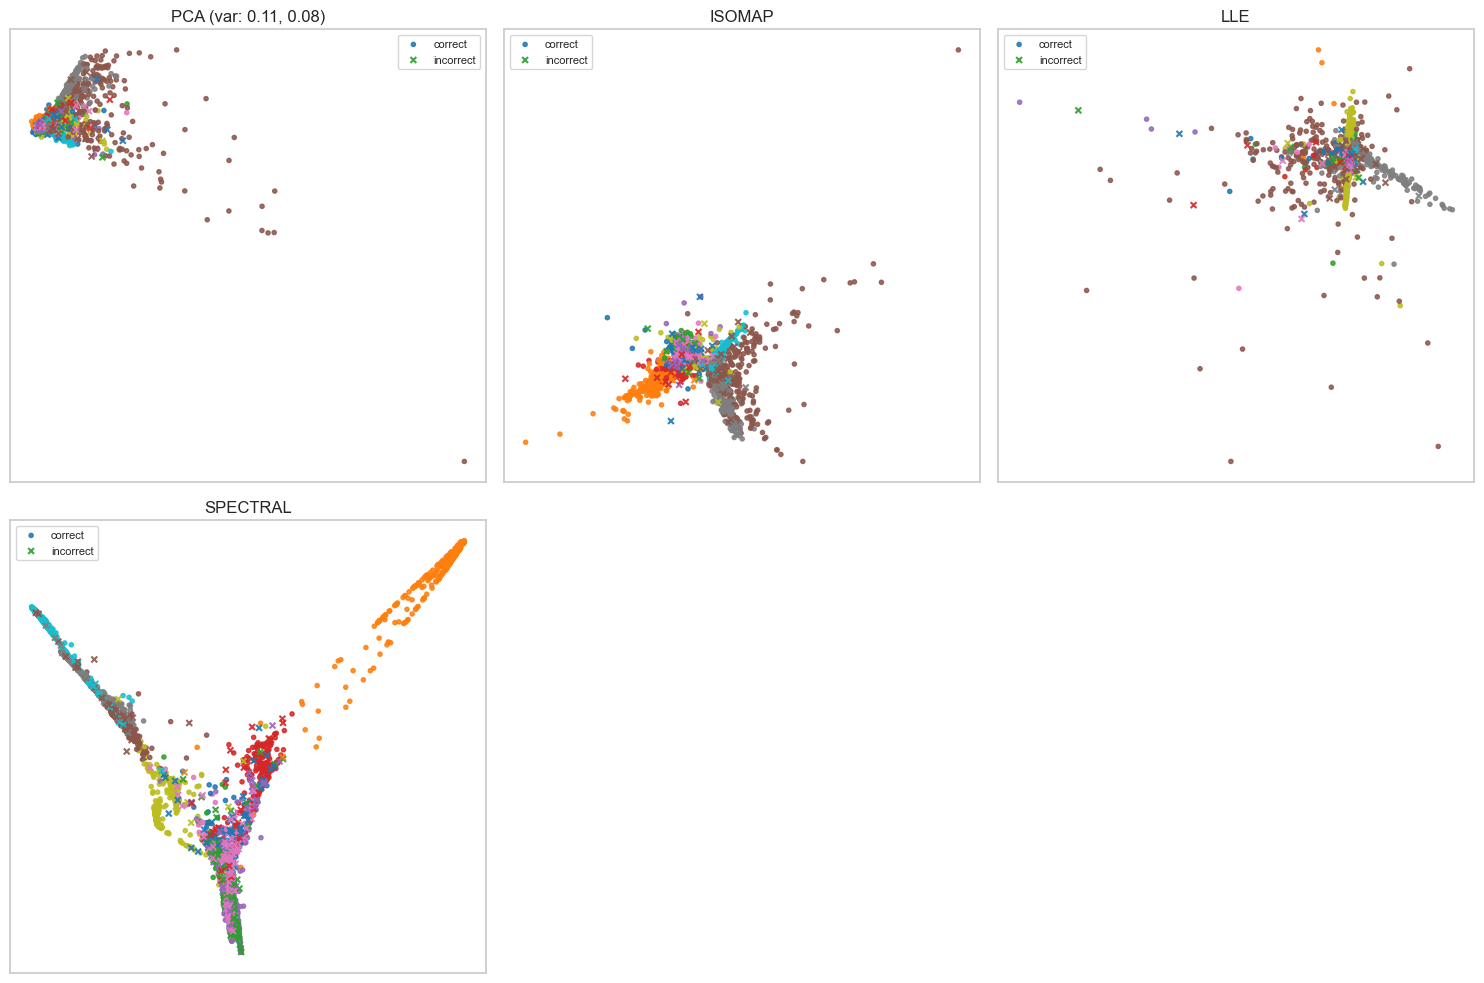

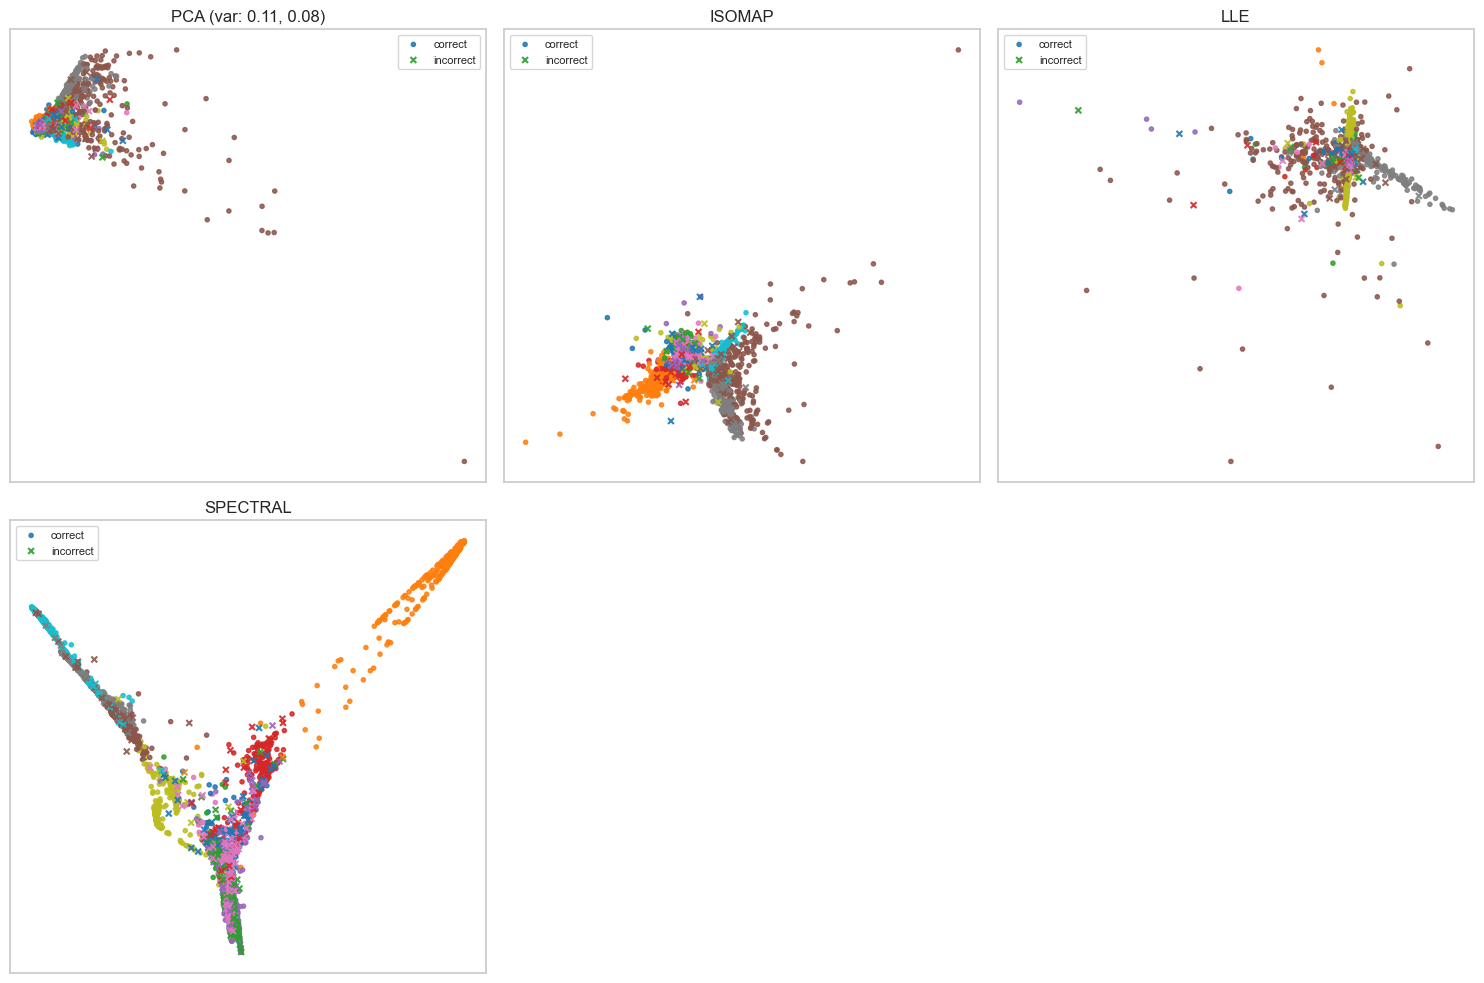

In [9]:
# Compute multiple embeddings (fast; subsamples if large) and plot a grid
df_demo = pd.read_csv(demo_fpath)
X, true_y, pred_y, correct = analysis.extract_activation_matrix(df_demo)
emb = analysis.compute_embeddings(X, methods=["pca","tsne","isomap","lle","spectral"], max_points=3000, random_state=42)
fig = analysis.plot_embedding_grid(emb, true_y=true_y[emb.get('indices')] if true_y is not None else None,
                                   correct=correct[emb.get('indices')] if correct is not None else None,
                                   cols=3, figsize=(15,10))
fig

In [10]:
# Save the grid via the visualization helper and show the output path
out_png = make_activation_embedding_plots_for_file(demo_fpath, methods=["pca","tsne","isomap","lle","spectral"], max_points=3000)
out_png

WindowsPath('C:/Users/Adam/Desktop/tfg/code/runs/fashion_cv_l1_dropoutLows_l2/baseline/fold1/embeddings/activations_collected_epoch20_fold1_embeddings.png')